# 2.3 Least Squares and Nearest Neighbors

### 2.3.3 From Least Squares to Nearest Neighbors

1. Generates 10 means $m_k$ from a bivariate Gaussian distrubition for each color:
   - $N((1, 0)^T, \textbf{I})$ for <span style="color: blue">BLUE</span>
   - $N((0, 1)^T, \textbf{I})$ for <span style="color: orange">ORANGE</span>
2. For each color generates 100 observations as following:
   - For each observation it picks $m_k$ at random with probability 1/10.
   - Then generates a $N(m_k,\textbf{I}/5)$


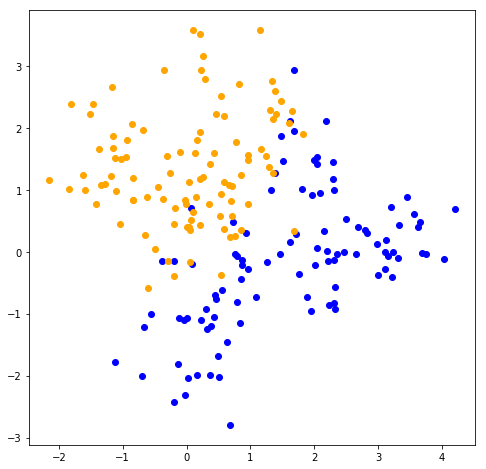

In [2]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt

def generate_data(size, mean):
    identity = np.identity(2)
    m = np.random.multivariate_normal(mean, identity, 10)
    return np.array([
        np.random.multivariate_normal(random.choice(m), identity / 5)
        for _ in range(size)
    ])

sample_size = 100
blue_data = generate_data(sample_size, [1, 0])
orange_data = generate_data(sample_size, [0, 1])

# plotting
fig = plt.figure(figsize = (8, 8))
axes = fig.add_subplot(1, 1, 1)
axes.plot(blue_data[:, 0], blue_data[:, 1], 'o', color='blue')
axes.plot(orange_data[:, 0], orange_data[:, 1], 'o', color='orange')
plt.show()

### 2.3.1 Linear Models and Least Squares

$$\hat{Y} = \hat{\beta_0} + \sum_{j=1}^{p} X_j\hat{\beta_j}$$

where $\hat{\beta_0}$ is the intercept, also know as the *bias*. It is convenient to include the constant variable 1 in X and $\hat{\beta_0}$ in the vector of coefficients $\hat{\beta}$, and then write as: 

$$\hat{Y} = X^T\hat{B} $$

#### Residual sum of squares

How to fit the linear mode to a set of training data? Pick the coefficients $\beta$ to minimize the *residual sum of squares*:

$$RSS(\beta) = \sum_{i=1}^{N} (y_i - x_i^T\beta) ^ 2 = (\textbf{y} - \textbf{X}\beta)^T (\textbf{y} - \textbf{X}\beta)$$

where $\textbf{X}$ is an $N \times p$ matrix with each row an input vector, and $\textbf{y}$ is an N-vector of the outputs in the training set.

In [3]:
data_x = np.concatenate((blue_data, orange_data))

X = np.hstack((np.ones((len(data_x), 1)), data_x))
Y = np.concatenate((np.zeros(100), np.ones(100))) 
beta = np.linalg.lstsq(X, Y, rcond = None)[0]
print("beta = ", beta)


beta =  [ 0.52228479 -0.19064717  0.21912191]


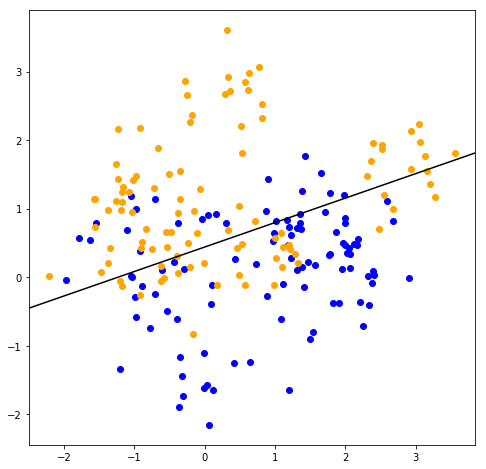

In [59]:
%matplotlib inline
plot_xlim = axes.get_xlim()
plot_ylim = axes.get_ylim()

find_y = lambda x: (0.5 - beta[0] - x * beta[1]) / beta[2]
axes.plot(plot_xlim, list(map(find_y, plot_xlim)), color = 'black')

# TODO: Figure out a way to preserve the limits without reseting them back.
axes.set_xlim(plot_xlim)
axes.set_ylim(plot_ylim)

fig